In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras
import seaborn as sns
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

plt.style.use('ggplot')
import librosa
from librosa import feature
from librosa import display

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

genres = [
    'blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop',
    'reggae', 'rock'
]

In [2]:
# load dataframe from csv
dfFeatures = pd.read_csv("music_features_updated.csv")


# extract genres for labels
genreList = dfFeatures['genre']

# drop genres and filenames for training data
dfFeatures= dfFeatures.drop(columns = ['filename', 'genre'])

dfFeatures.head()

,chroma_stft_mean,chroma_stft_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.342053,0.089037,1782.622682,116977.082472,2020.556328,84328.680518,3845.075667,8.328459e+05,0.080111,0.000709,...,0.530103,69.972038,-2.870996,35.479565,0.306077,43.506840,-2.700369,58.693989,2.370232,48.047718
1,0.358000,0.090658,1364.273766,291346.764439,1842.030467,221553.848927,2976.303348,2.452152e+06,0.055211,0.001548,...,-0.463962,62.798424,0.497853,61.236259,0.039326,48.482971,-1.083576,54.454639,-0.112309,53.948948
2,0.382027,0.087238,1521.556846,224961.620877,1736.799388,64062.188124,3028.062974,8.508550e+05,0.070182,0.001670,...,2.917833,37.905025,-6.660074,53.707203,-2.039234,48.657555,-2.045270,45.731483,-2.697336,28.559635
3,0.391765,0.094778,947.018874,135762.858041,1427.836298,122599.100317,1863.946038,9.467861e+05,0.030092,0.000291,...,-0.273013,33.782215,0.231585,31.175877,2.437521,30.588255,1.284240,26.782133,-2.200283,31.076508
4,0.316456,0.090731,2046.427867,540932.742010,1858.463045,111903.623326,4005.025898,2.115368e+06,0.116385,0.003541,...,-2.115260,129.746536,-8.198335,71.464584,-1.059961,62.674892,-3.900608,59.124683,-12.995133,57.077927


In [3]:
# standardize data  
scaler = StandardScaler()
X = scaler.fit_transform(np.array(dfFeatures.iloc[:, :-1], dtype = float))

# encode labels 
encoder = LabelEncoder()
y = encoder.fit_transform(genreList)

# split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=2)

In [4]:
# initialize keras network
model = keras.Sequential()
model.add(keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [5]:
# configure model for training
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
# train model

# https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
from keras import callbacks

#callback to prevent overfitting
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)


history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=128,
                    callbacks =[earlystopping])

Epoch 1/100
5/5 [==============================] - 1s 259ms/step - loss: 2.3042 - accuracy: 0.1435 - val_loss: 2.0177 - val_accuracy: 0.3850
Epoch 2/100
5/5 [==============================] - 0s 13ms/step - loss: 1.8865 - accuracy: 0.4278 - val_loss: 1.7834 - val_accuracy: 0.3850
Epoch 3/100
5/5 [==============================] - 0s 12ms/step - loss: 1.6332 - accuracy: 0.4625 - val_loss: 1.6039 - val_accuracy: 0.4200
Epoch 4/100
5/5 [==============================] - 0s 12ms/step - loss: 1.4677 - accuracy: 0.5256 - val_loss: 1.4769 - val_accuracy: 0.4700
Epoch 5/100
5/5 [==============================] - 0s 13ms/step - loss: 1.3065 - accuracy: 0.5946 - val_loss: 1.3714 - val_accuracy: 0.5150
Epoch 6/100
5/5 [==============================] - 0s 13ms/step - loss: 1.1525 - accuracy: 0.6399 - val_loss: 1.2784 - val_accuracy: 0.5250
Epoch 7/100
5/5 [==============================] - 0s 13ms/step - loss: 1.0414 - accuracy: 0.6577 - val_loss: 1.1957 - val_accuracy: 0.5650
Epoch 8/100
5/5 [==

In [7]:
test_loss, test_acc  = model.evaluate(X_test, y_test, batch_size=128)


2/2 [==============================] - 0s 2ms/step - loss: 0.9865 - accuracy: 0.6550


Text(0.5, 1.0, 'Confusion Matrix: Base Model')

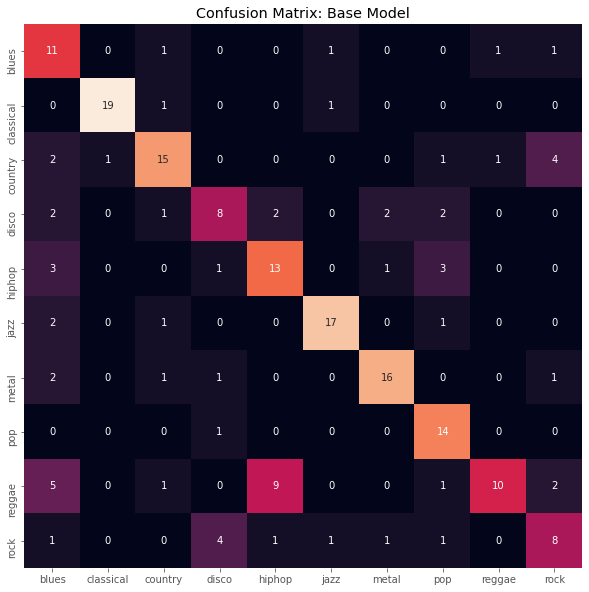

In [8]:
prediction = model.predict(X_test)
y_pred = []
for index, y_encode in enumerate(prediction):
    y_pred.append(np.argmax(y_encode))
corrMatrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(corrMatrix, annot = True, xticklabels=genres, yticklabels=genres, cbar=False).set_title("Confusion Matrix: Base Model")

Text(0.5, 0, 'Epoch')

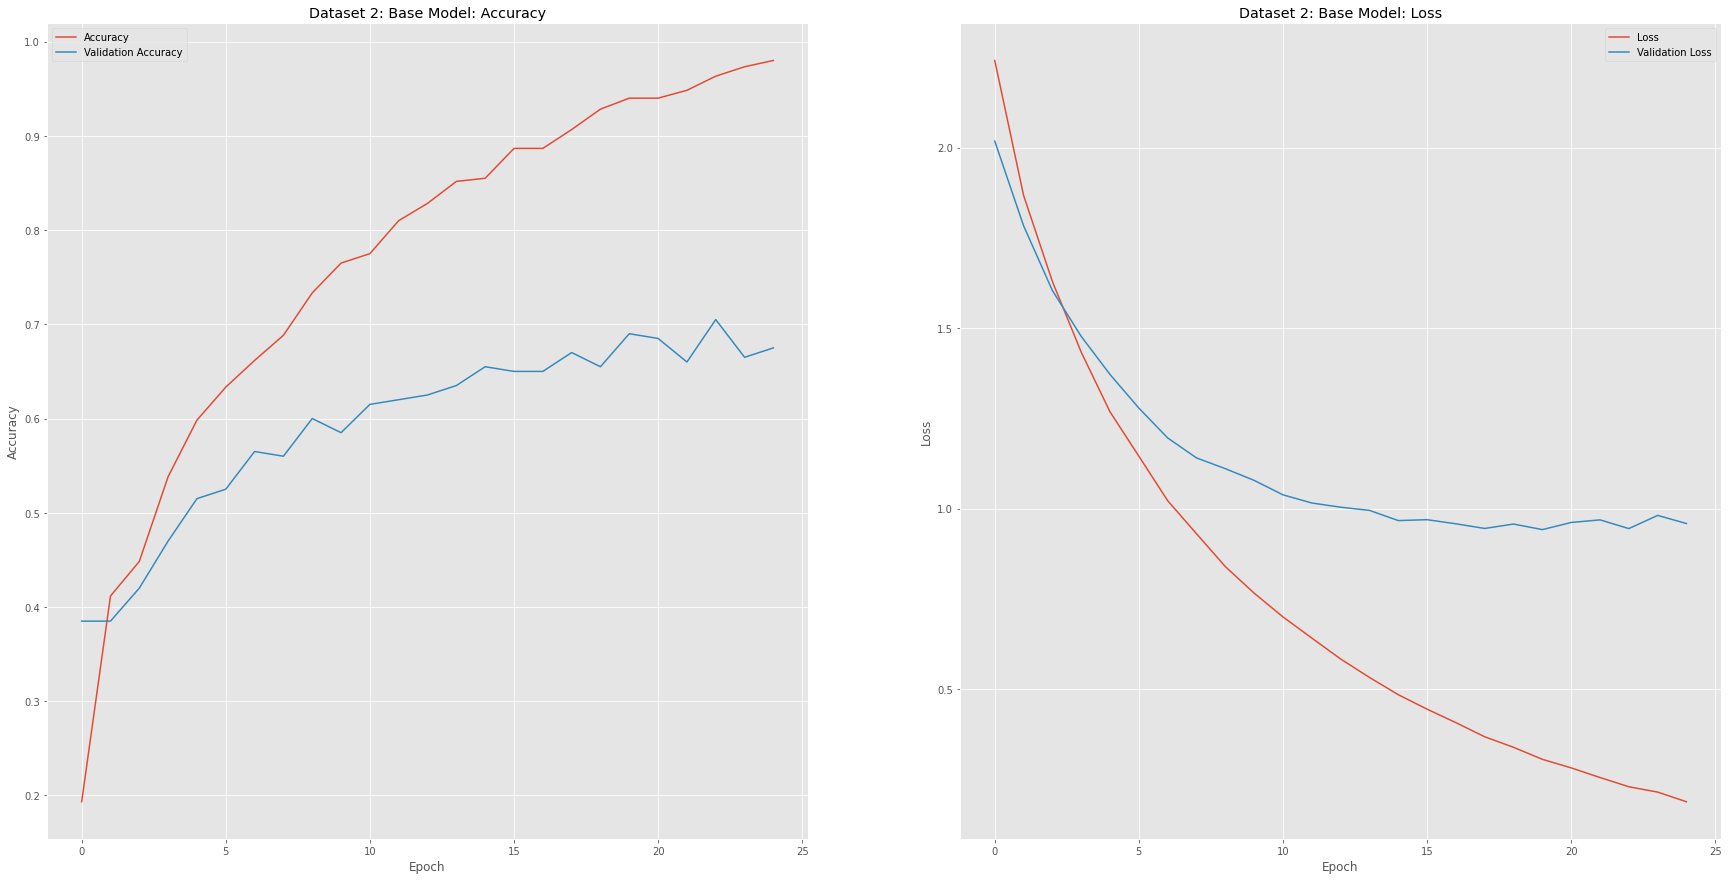

In [9]:
fig, ax = plt.subplots(1,2,figsize=(30,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[0].legend(["Accuracy", "Validation Accuracy"])
ax[1].legend(["Loss", "Validation Loss"])
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Dataset 2: Base Model: Accuracy")
ax[1].set_title("Dataset 2: Base Model: Loss")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")

In [10]:
# initialize keras network
modeldropout = keras.Sequential()
modeldropout.add(keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
modeldropout.add(keras.layers.Dropout(0.2))
modeldropout.add(keras.layers.Dense(128, activation='relu'))
modeldropout.add(keras.layers.Dropout(0.2))
modeldropout.add(keras.layers.Dense(64, activation='relu'))
modeldropout.add(keras.layers.Dropout(0.2))
modeldropout.add(keras.layers.Dense(10, activation='softmax'))

In [11]:
modeldropout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history = modeldropout.fit(X_train,
                    y_train,
                    epochs=100,
                    callbacks =[earlystopping],
                    validation_data=(X_val, y_val),
                    batch_size=128)

Epoch 1/100
5/5 [==============================] - 1s 97ms/step - loss: 2.2889 - accuracy: 0.1336 - val_loss: 2.0887 - val_accuracy: 0.3500
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 2.0781 - accuracy: 0.2959 - val_loss: 1.9089 - val_accuracy: 0.3900
Epoch 3/100
5/5 [==============================] - 0s 15ms/step - loss: 1.9011 - accuracy: 0.3888 - val_loss: 1.7434 - val_accuracy: 0.4150
Epoch 4/100
5/5 [==============================] - 0s 12ms/step - loss: 1.7440 - accuracy: 0.4202 - val_loss: 1.6153 - val_accuracy: 0.4350
Epoch 5/100
5/5 [==============================] - 0s 15ms/step - loss: 1.6275 - accuracy: 0.4423 - val_loss: 1.5181 - val_accuracy: 0.4550
Epoch 6/100
5/5 [==============================] - 0s 15ms/step - loss: 1.4732 - accuracy: 0.4906 - val_loss: 1.4210 - val_accuracy: 0.4600
Epoch 7/100
5/5 [==============================] - 0s 13ms/step - loss: 1.4446 - accuracy: 0.4765 - val_loss: 1.3259 - val_accuracy: 0.5000
Epoch 8/100
5/5 [===

In [13]:
test_loss, test_acc  = modeldropout.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 0s 4ms/step - loss: 0.9428 - accuracy: 0.6900


Text(0.5, 1.0, 'Confusion Matrix: Model w/ Dropout')

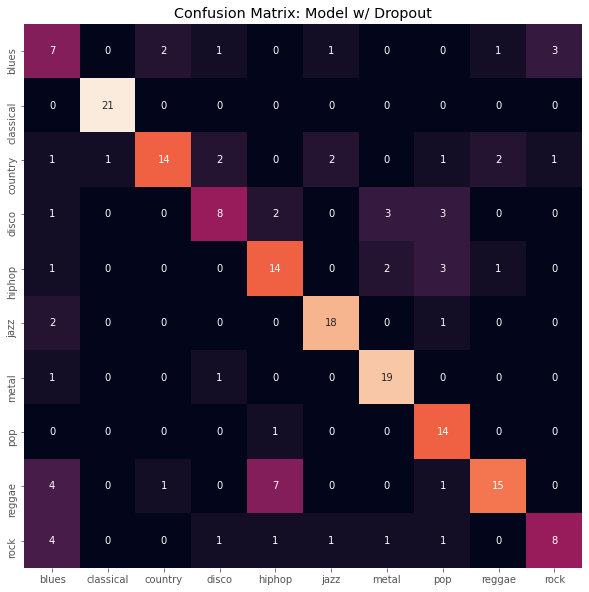

In [14]:
prediction = modeldropout.predict(X_test)
y_pred = []
for index, y_encode in enumerate(prediction):
    y_pred.append(np.argmax(y_encode))
corrMatrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(corrMatrix, annot = True, xticklabels=genres, yticklabels=genres, cbar=False).set_title("Confusion Matrix: Model w/ Dropout")

Text(0.5, 0, 'Epoch')

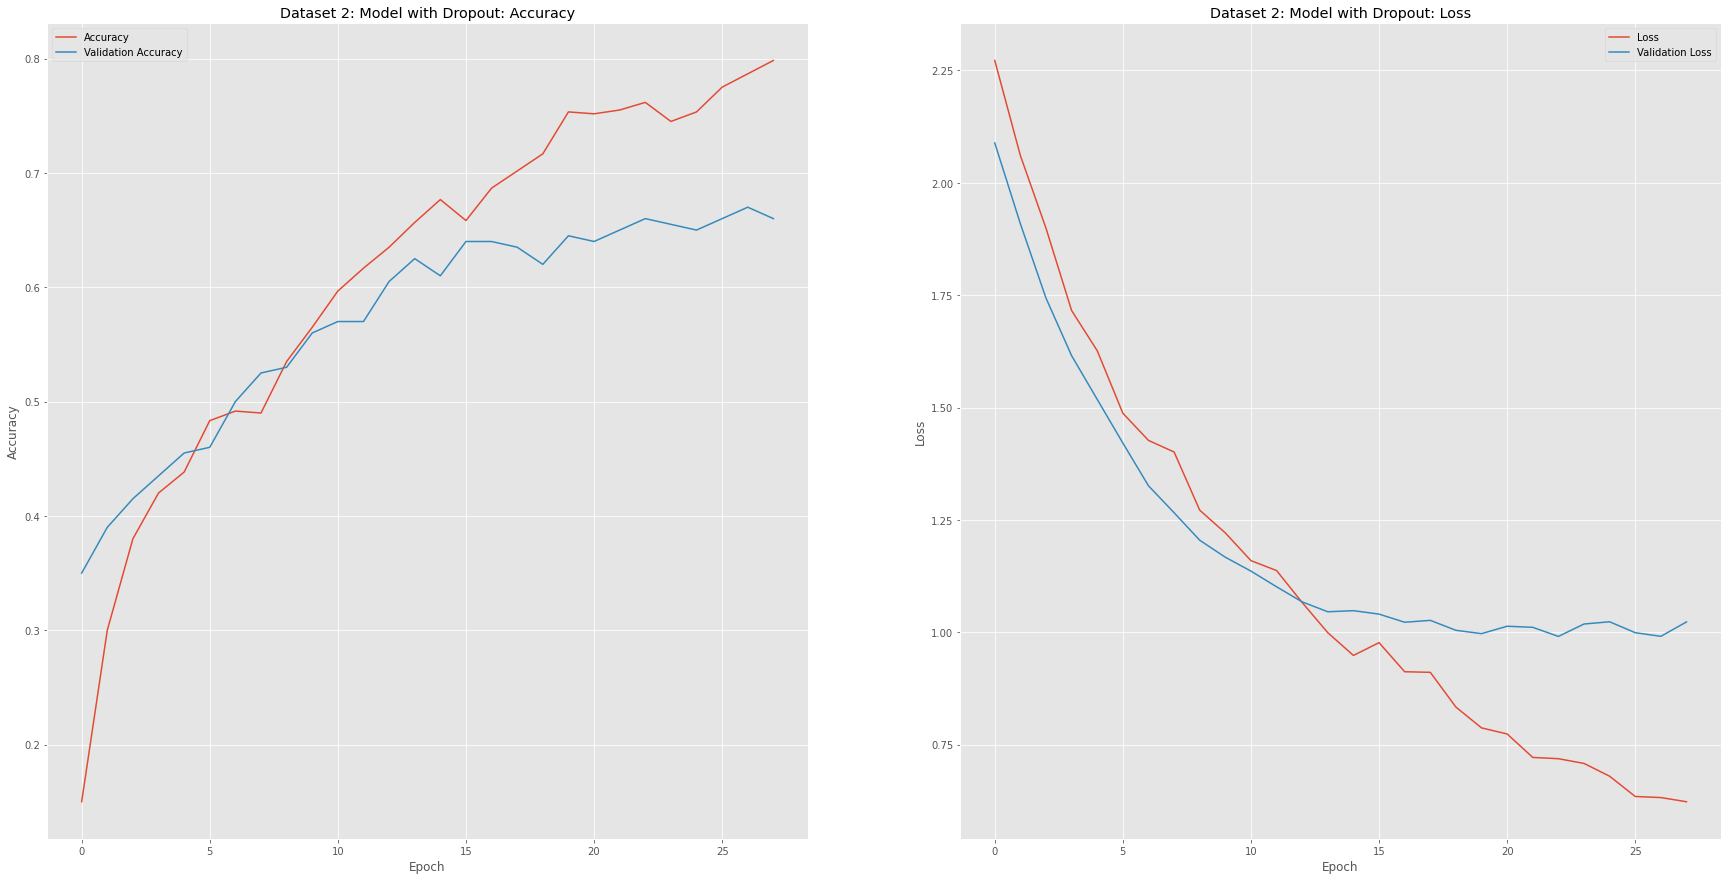

In [15]:
fig, ax = plt.subplots(1,2,figsize=(30,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[0].legend(["Accuracy", "Validation Accuracy"])
ax[1].legend(["Loss", "Validation Loss"])
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Dataset 2: Model with Dropout: Accuracy")
ax[1].set_title("Dataset 2: Model with Dropout: Loss")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")

In [16]:
modelReg = keras.Sequential()
modelReg.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4), input_shape=(X_train.shape[1],)))
modelReg.add(keras.layers.Dropout(0.2))
modelReg.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
modelReg.add(keras.layers.Dropout(0.2))
modelReg.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
modelReg.add(keras.layers.Dropout(0.2))
modelReg.add(keras.layers.Dense(10, activation='softmax', activity_regularizer=tf.keras.regularizers.l2(1e-4)))

modelReg.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
history = modelReg.fit(X_train,
                    y_train,
                    epochs=100,
                    callbacks =[earlystopping],
                    validation_data=(X_val, y_val),
                    batch_size=128)

Epoch 1/100
5/5 [==============================] - 1s 57ms/step - loss: 2.4429 - accuracy: 0.0691 - val_loss: 2.1972 - val_accuracy: 0.2850
Epoch 2/100
5/5 [==============================] - 0s 14ms/step - loss: 2.1781 - accuracy: 0.2179 - val_loss: 2.0594 - val_accuracy: 0.4050
Epoch 3/100
5/5 [==============================] - 0s 13ms/step - loss: 2.0259 - accuracy: 0.3283 - val_loss: 1.9255 - val_accuracy: 0.4250
Epoch 4/100
5/5 [==============================] - 0s 13ms/step - loss: 1.8864 - accuracy: 0.3776 - val_loss: 1.7853 - val_accuracy: 0.4400
Epoch 5/100
5/5 [==============================] - 0s 13ms/step - loss: 1.7216 - accuracy: 0.4542 - val_loss: 1.6651 - val_accuracy: 0.4450
Epoch 6/100
5/5 [==============================] - 0s 14ms/step - loss: 1.6583 - accuracy: 0.4520 - val_loss: 1.5532 - val_accuracy: 0.4600
Epoch 7/100
5/5 [==============================] - 0s 14ms/step - loss: 1.5295 - accuracy: 0.4788 - val_loss: 1.4605 - val_accuracy: 0.4800
Epoch 8/100
5/5 [===

In [18]:
test_loss, test_acc  = modelReg.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 0s 2ms/step - loss: 0.9811 - accuracy: 0.6850


Text(69.0, 0.5, 'True Classification')

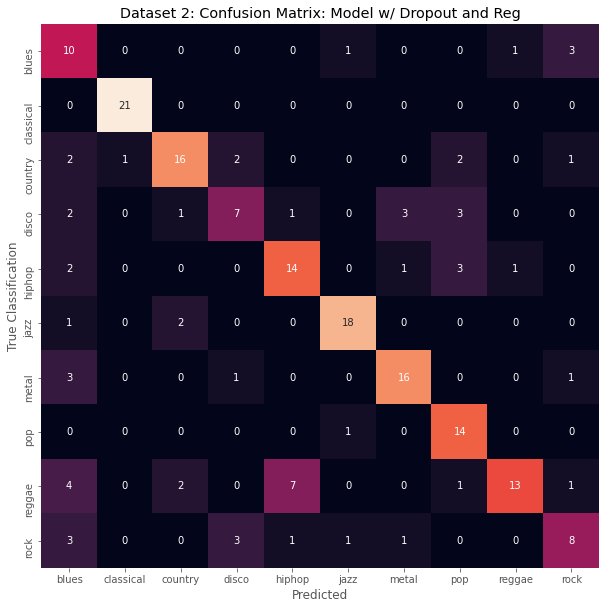

In [22]:
prediction = modelReg.predict(X_test)
y_pred = []
for index, y_encode in enumerate(prediction):
    y_pred.append(np.argmax(y_encode))
corrMatrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(corrMatrix, annot = True, xticklabels=genres, yticklabels=genres, cbar=False).set_title("Dataset 2: Confusion Matrix: Model w/ Dropout and Reg")
ax.set_xlabel("Predicted")
ax.set_ylabel("True Classification")

Text(0.5, 0, 'Epoch')

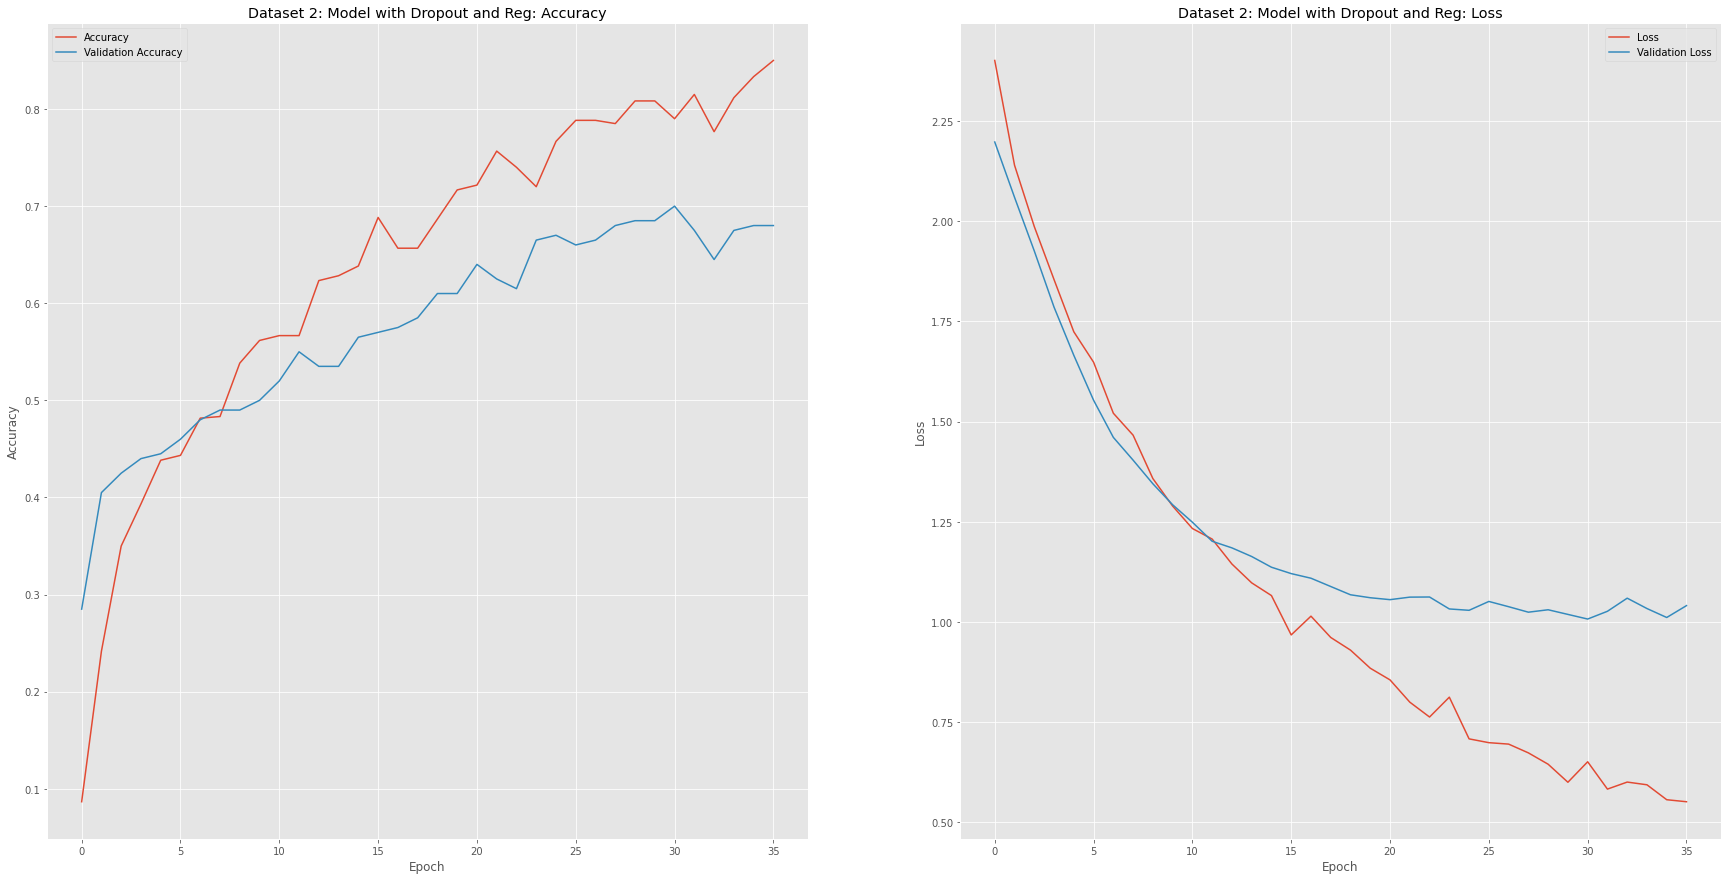

In [20]:
fig, ax = plt.subplots(1,2,figsize=(30,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[0].legend(["Accuracy", "Validation Accuracy"])
ax[1].legend(["Loss", "Validation Loss"])
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Dataset 2: Model with Dropout and Reg: Accuracy")
ax[1].set_title("Dataset 2: Model with Dropout and Reg: Loss")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")